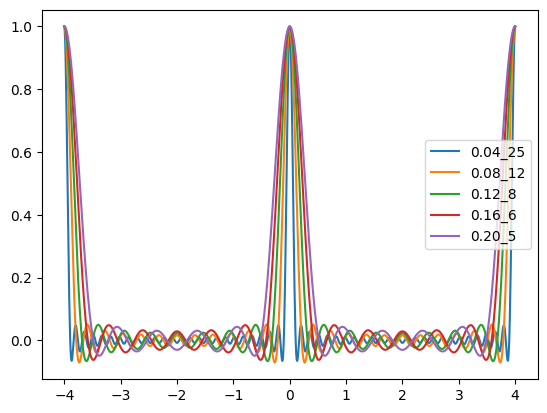

[<Axes: >]

In [1]:
import numpy as np
import sympy
import sympy as sp
from matplotlib import pyplot as plt

from ofex.classical_algorithms.funcapprox import plot_functions
from ofex.classical_algorithms.filter_functions import chebyshev_find_n, chebyshev_fluctuation, chebyshev_filter_fourier,\
    gaussian_width_fit_to_chebyshev, gaussian_function_fourier, kaiser_fluctuation, kaiser_find_alpha_from_fluct, \
    kaiser_find_alpha_from_width, kaiser_width, kaiser_find_n, kaiser_filter_fourier

import warnings
warnings.filterwarnings("ignore")

width_list = np.linspace(0.04, 0.2, 5)
period = 4
x = sp.Symbol('x')

gauss_func_list = dict()
for w in width_list:
    n_fourier = int(1/w)
    g, _, _ = gaussian_function_fourier(n_fourier, w, 0.0, period, sym_x=x)
    gauss_func_list[f"{w:0.2f}_{n_fourier}"] = g

plot_functions(gauss_func_list, x, x_points=np.linspace(-4, 4, 1000))


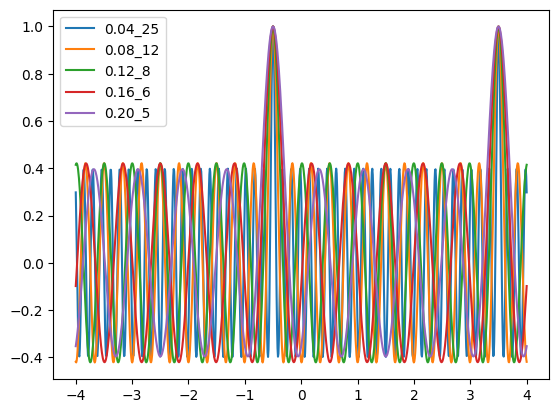

[<Axes: >]

In [2]:
cheby_func_list = dict()
for w in width_list:
    n_fourier = int(1/w)
    g, _, _ = chebyshev_filter_fourier(n_fourier, w, -0.5, period, sym_x=x)
    cheby_func_list[f"{w:0.2f}_{n_fourier}"] = g

plot_functions(cheby_func_list, x, x_points=np.linspace(-4, 4, 1000))

# Parameter Rescaling
Expressions for each filter is
$$
\begin{split}
    g(x;\sigma, p, n) =& \left(\sum_{k=-n}^{n} c_k\right)^{-1}\sum_{k=-n}^n c_k e^{ik\omega x};\quad c_k=e^{-\tfrac{1}{2}\left(k\omega \sigma\right)^2}\left(\mathrm{erf}\left(\frac{\pi + ik(\pi\sigma\omega)^2}{\sqrt{2}\sigma\omega}\right)+\mathrm{erf}\left(\frac{\pi - ik(\pi\sigma\omega)^2}{\sqrt{2}\sigma\omega}\right)\right)\\
    f(x;\sigma, p, n) =&\frac{T_n(1+2y(x))}{T_n(1+2y(0))};\quad y(x)=\frac{\cos \omega x - \cos \omega\sigma}{1 + \cos \omega \sigma}
\end{split}
$$
where $\omega = 2\pi/p$.
A naive comparison approach that treats $\sigma$ and $n$ identically produces the following plot, where neither the width nor the side fluctuations are controlled.

10
20
30


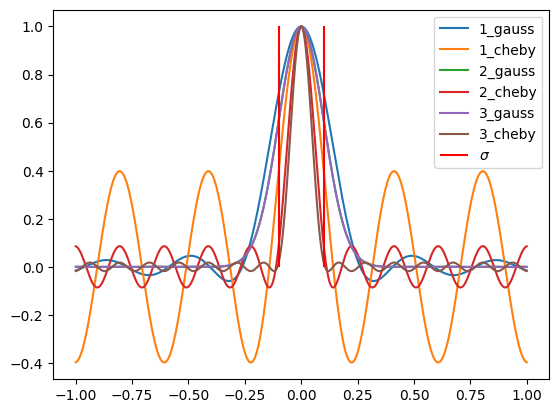

In [3]:
w = 0.1

plot_dict = dict()
for n_factor in range(1,4):
    n_fourier = int(1/w) * n_factor
    print(n_fourier)
    gauss, _, _ = gaussian_function_fourier(n_fourier, w, 0.0, period, sym_x=x)
    cheby, _, _ = chebyshev_filter_fourier(n_fourier, w, 0.0, period, sym_x=x)
    plot_dict[f"{n_factor}_gauss"] = gauss
    plot_dict[f"{n_factor}_cheby"] = cheby
plot_functions(plot_dict, x, x_points=np.linspace(-1, 1, 1000), plot=False)
plt.vlines((-w, w), 0.0, 1.0, color="red", label=r"$\sigma$")
plt.legend()
plt.show()
# plt.vlines((-np.pi * w, np.pi * w), 0.0, 1.0)

To resolve this issue, we adjust parameters of gaussian filter for a fair comparison. Consider the Chebyshev side fluctuation:
$$
    |f(x)| \le \left[T_n\left( 1+2\frac{1-\cos \omega \sigma}{1+\cos \omega \sigma} \right)\right]^{-1}, \quad \sigma<|x|<p/2
$$

We want to fit the parameter $\sigma_0$ of Gaussian function $g(x;\sigma_0,p,n)$ so that
$$
    |f(\sigma;\sigma, p, n)|=\left[T_n\left( 1+2\frac{1-\cos \omega \sigma}{1+\cos \omega \sigma} \right)\right]^{-1} \approx |g(\sigma;\sigma_0, p, n)| \approx e^{-\frac{\sigma^2}{2\sigma_0^2}}
$$
given that $n\sigma_0 > 1$ and thus small enough approximation error.

Thus, we first set the target fluctuation and determine the Chebyshev order that satisfies the fluctuation condition. Next, we adjust the width of the Gaussian filter to coincides with the Chebyshev filter at the edges. The results are as follows.


n_cheby: 64
w_gaussian (Precise): 0.02065681849981393
2.0766498958577015
Cheby fluc = 0.009402863354734049


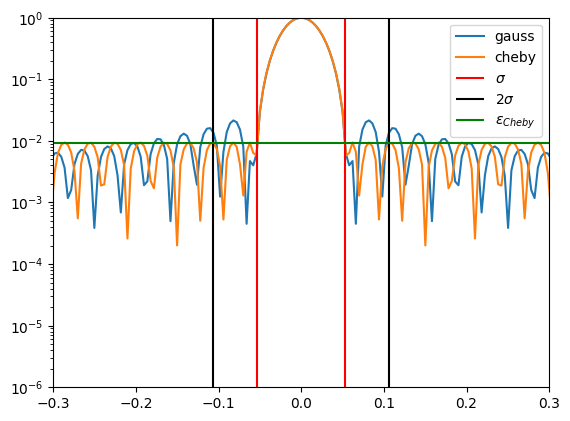

In [4]:
w_cheby = 0.0533
target_fluc = 0.01

n_cheby = chebyshev_find_n(w_cheby, period, target_fluc)
print(f"n_cheby: {n_cheby}")
w_gaussian = gaussian_width_fit_to_chebyshev(n_cheby, w_cheby, period, precise=True)
print(f"w_gaussian (Precise): {w_gaussian}")

print(n_cheby * w_gaussian * 2 * np.pi / period)

cheby_fluc = chebyshev_fluctuation(n_cheby, w_cheby, period)
print(f"Cheby fluc = {cheby_fluc}")

gauss, _, _ = gaussian_function_fourier(n_cheby, w_gaussian, 0.0, period, sym_x=x)
cheby, _, _ = chebyshev_filter_fourier(n_cheby, w_cheby, 0.0, period, sym_x=x, high_order_repr=True)
if n_cheby > 60:
    axes = plot_functions({"gauss":sympy.Abs(gauss), "cheby":sympy.Abs(cheby)}, x, x_points=np.linspace(-2, 2, 1000), plot=False)
else:
    axes = plot_functions({"gauss":gauss, "cheby":cheby}, x, x_points=np.linspace(-2, 2, 1000), plot=False)

for ax in axes:
    ax.vlines((-w_cheby, w_cheby), -0.5, 1.0, color="red", label=r"$\sigma$")
    ax.vlines((-2 * w_cheby, 2 * w_cheby), -0.5, 1.0, color="black", label=r"$2\sigma$")
    ax.hlines(cheby_fluc, -1, 1, color="green", label=r"$\epsilon_{Cheby}$")
    if n_cheby > 60:
        ax.set_ylim(1e-6, 1.0)
        ax.set_yscale('log')
    else:
        ax.set_ylim(-0.5, 1.0)
    ax.set_xlim(-0.3, 0.3)
plt.legend()
plt.show()


# Kaiser Filter

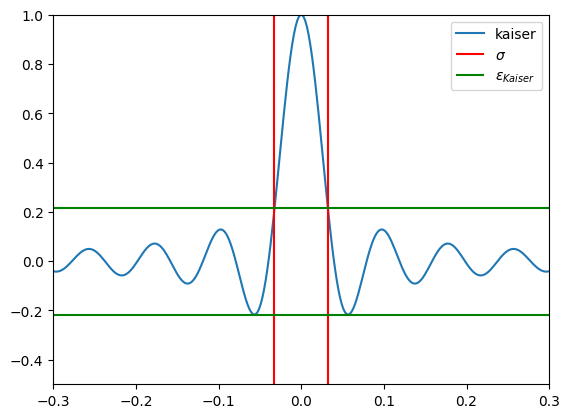

In [5]:
n_fourier = 50
alpha = 0.02
period = 4.0

ksr, _, _ = kaiser_filter_fourier(n_fourier, alpha, 0.0, period)
ksr_w = kaiser_width(n_fourier, alpha, period)
ksr_fluc = kaiser_fluctuation(alpha)

axes = plot_functions({"kaiser": ksr}, x, x_points=np.linspace(-1, 1, 1000), plot=False)
for ax in axes:
    ax.vlines((-ksr_w, ksr_w), -0.5, 1.0, color="red", label=r"$\sigma$")
    ax.hlines((-ksr_fluc, ksr_fluc), -1, 1, color="green", label=r"$\epsilon_{Kaiser}$")
    ax.set_ylim(-0.5, 1.0)
    ax.set_xlim(-0.3, 0.3)

plt.legend()
plt.show()

# Filter Comparison

w_gaussian (Precise): 2.6356319630096326e-05
alpha: 0.710040582305474
0.001159211481758051
n_cheby: 28
n_kaiser: 31
Cheby fluc = 0.189960323916051
Kaiser fluc = 0.20000000000000004


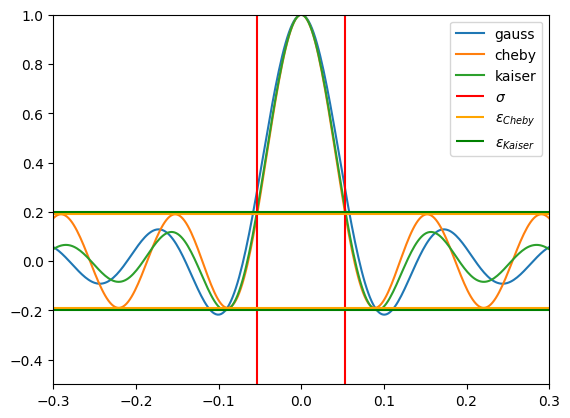

In [6]:
target_fluc = 0.2
target_width = 0.0533
period = 4.0


n_cheby = chebyshev_find_n(target_width, period, target_fluc)
w_gaussian = gaussian_width_fit_to_chebyshev(n_cheby, target_width, period, precise=True)
print(f"w_gaussian (Precise): {w_gaussian}")

try:
    ksr_n = n_cheby
    ksr_alpha = kaiser_find_alpha_from_width(n_cheby, target_width, period)
except ValueError:
    ksr_alpha = kaiser_find_alpha_from_fluct(target_fluc)
    ksr_n = kaiser_find_n(ksr_alpha, target_width, period)
print(f"alpha: {ksr_alpha}")
ksr_fluc = kaiser_fluctuation(ksr_alpha)

print(n_cheby * w_gaussian * 2 * np.pi / period)

cheby_fluc = chebyshev_fluctuation(n_cheby, target_width, period)

print(f"n_cheby: {n_cheby}")
print(f"n_kaiser: {ksr_n}")

print(f"Cheby fluc = {cheby_fluc}")
print(f"Kaiser fluc = {ksr_fluc}")

gauss, _, _ = gaussian_function_fourier(n_cheby, w_gaussian, 0.0, period, sym_x=x)
cheby, _, _ = chebyshev_filter_fourier(n_cheby, target_width, 0.0, period, sym_x=x, high_order_repr=True)
kaiser, _, _ = kaiser_filter_fourier(ksr_n, ksr_alpha, 0.0, period, sym_x=x)
if min(n_cheby, ksr_n) > 60:
    axes = plot_functions({"gauss": sp.Abs(gauss), "cheby": sp.Abs(cheby), "kaiser": sp.Abs(kaiser)},
                            x, x_points=np.linspace(-1, 1, 1000), plot=False)
else:
    axes = plot_functions({"gauss":gauss, "cheby":cheby, "kaiser":kaiser}, x, x_points=np.linspace(-1, 1, 1000), plot=False)

for ax in axes:
    if min(n_cheby, ksr_n) > 60:
        ax.set_ylim(1e-5, 1.0)
        ax.set_yscale('log')
    else:
        ax.set_ylim(-0.5, 1.0)
    ax.vlines((-target_width, target_width), -0.5, 1.0, color="red", label=r"$\sigma$")
    ax.hlines((-cheby_fluc, cheby_fluc), -1, 1, color="orange", label=r"$\epsilon_{Cheby}$")
    ax.hlines((-ksr_fluc, ksr_fluc), -1, 1, color="green", label=r"$\epsilon_{Kaiser}$")
    ax.set_xlim(-0.3, 0.3)
plt.legend()
plt.show()


# High-Order Chebyshev Demonstration


n_cheby: 200
w_gaussian (Precise): 0.011887182515044923
3.734468526114617
Cheby fluc = 1.0636020079109693e-07


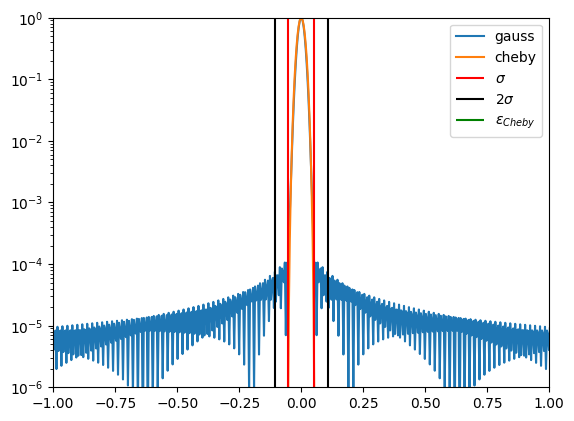

In [7]:
n_cheby = 200
print(f"n_cheby: {n_cheby}")
w_gaussian = gaussian_width_fit_to_chebyshev(n_cheby, w_cheby, period, precise=True)
print(f"w_gaussian (Precise): {w_gaussian}")

print(n_cheby * w_gaussian * 2 * np.pi / period)

cheby_fluc = chebyshev_fluctuation(n_cheby, w_cheby, period)
print(f"Cheby fluc = {cheby_fluc}")

gauss, _, _ = gaussian_function_fourier(n_cheby, w_gaussian, 0.0, period, sym_x=x)
cheby, _, _ = chebyshev_filter_fourier(n_cheby, w_cheby, 0.0, period, sym_x=x, high_order_repr=True)
if n_cheby > 60:
    axes = plot_functions({"gauss":sympy.Abs(gauss), "cheby":sympy.Abs(cheby)}, x, x_points=np.linspace(-2, 2, 1000), plot=False)
else:
    axes = plot_functions({"gauss":gauss, "cheby":cheby}, x, x_points=np.linspace(-2, 2, 1000), plot=False)

for ax in axes:
    ax.vlines((-w_cheby, w_cheby), -0.5, 1.0, color="red", label=r"$\sigma$")
    ax.vlines((-2 * w_cheby, 2 * w_cheby), -0.5, 1.0, color="black", label=r"$2\sigma$")
    ax.hlines(cheby_fluc, -1, 1, color="green", label=r"$\epsilon_{Cheby}$")
    if n_cheby > 60:
        ax.set_ylim(1e-6, 1.0)
        ax.set_yscale('log')
    else:
        ax.set_ylim(-0.5, 1.0)
    ax.set_xlim(-1.0, 1.0)
plt.legend()
plt.show()
